In [68]:
import numpy as np
import nemos as nmo
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
sn_data = np.load('092624Ac7_spatial_noise.npy',allow_pickle=True)
sn_data

array([{'file_name': '092624A', 'source_id': 3, 'epoch_group_id': 7, 'epoch_block_id': 24, 'epoch_id': 282, 'channel_name': 'Amp1', 'antialias': 'T', 'color_noise_mode': '1 pattern', 'color_noise_distribution': 'gaussian', 'frame_dwell': 10, 'number_of_epochs': 1, 'pre_time': 500.0, 'resolution_x': 1, 'resolution_y': 1, 'rstar_mean': 655.4, 'seed_change_mode': 'increment only', 'seed_start_value': 1, 'size_x': 2000.0, 'size_y': 2000.0, 'stim_time': 100000.0, 'tail_time': 500.0, 'contrast_1': 1.0, 'contrast_2': 0.0, 'mean_level_1': 0.1, 'mean_level_2': 0.0, 'subsample_x': 1, 'subsample_y': 1, 'offset_seed': 4294967295, 'noise_seed': 1, 'spike_indices': array([[   5368,    5788,    6152,    6453,    6774,    7117,    7455,
                  7785,    8098,    8452,    8810,    9222,    9670,   10133,
                 10537,   10979,   11468,   11928,   12441,   12900,   13421,
                 13930,   14469,   14980,   15458,   15964,   16451,   16882,
                 17465,   18067,   

In [70]:
sn_data = pd.DataFrame.from_dict(sn_data)
sn_data = pd.json_normalize(sn_data[0])
sn_data['spike_indices'] = sn_data['spike_indices'].apply(lambda x: x[0] if isinstance(x, list) else x)
# # Explode spike_indices
sn_data = sn_data.explode('spike_indices').reset_index(drop=True)
# Adjust spike times with pre_time and filter for those within stim_time
sn_data['spike_times'] = sn_data.apply(
    lambda row: [((index / row['sample_rate']) - (row['pre_time'] / 1000.0))
                 for index in row['spike_indices'] 
                 if (0 <= ((index / row['sample_rate']) - (row['pre_time'] / 1000.0)) <= (row['stim_time'] / 1000.0))]
                 if row['spike_indices'] is not None else None,
    axis=1
)

In [71]:
def getMovie(attrs):
    
    # noiseGen = np.random.Generator(np.random.MT19937(seed=int(attrs['noise_seed'])))
    # offsetGen = np.random.Generator(np.random.MT19937(seed=int(attrs['offset_seed'])))
    noiseGen = np.random.RandomState(seed=int(attrs['noise_seed']))
    offsetGen = np.random.RandomState(seed=int(attrs['offset_seed']))
    
    nFrames = int(attrs['frame_rate'] * (attrs['pre_time'] + attrs['stim_time'] + attrs['tail_time']) / 1000)
    preFrames = int(attrs['frame_rate'] * attrs['pre_time'] / 1000)

    res = (int(attrs['resolution_y']), int(attrs['resolution_x']))
    subsample = (int(attrs['subsample_y']), int(attrs['subsample_x']))

    # mov = np.empty((nFrames, *res))
    tmp = np.empty(res)
    mov = np.empty((nFrames, res[0]*subsample[0], res[1]*subsample[1]))

    ct = attrs['contrast_1'] * attrs['mean_level_1']

    if attrs['color_noise_distribution'] == 'binary':
        noiseFn = lambda x,y: 2 * (noiseGen.rand(x,y) > 0.5) - 1
    elif attrs['color_noise_distribution'] == 'gaussian':
        noiseFn = lambda x,y: noiseGen.randn(x,y)
    elif attrs['color_noise_distribution'] == 'uniform':
        noiseFn = lambda x,y: 2 * noiseGen.rand(x,y) - 1

    for frame in np.arange(nFrames):
        if frame  - preFrames < 0:
            mov[frame] = np.clip(attrs['mean_level_1'], 0.0, 1.0)
        elif frame % attrs['frame_dwell']:
            mov[frame] = mov[frame - 1]
        else:
            # mov[frame] = np.clip(attrs['meanLevel'] + ct * noiseFn(*res), 0.0, min(2*attrs['meanLevel'], 1.0))
            tmp = np.clip(attrs['mean_level_1'] + ct * noiseFn(*res), 0.0, min(2*attrs['mean_level_1'], 1.0))
            
            # p = np.asarray((offsetGen.randint(1,2*attrs['subsampleX'] - 1, 1) - attrs['subsampleX'], offsetGen.randint(1,2*attrs['subsampleY'] - 1, 1) - attrs['subsampleY'])).flatten()
            p = (np.ceil(offsetGen.rand()*(2*attrs['subsample_x'] - 1) - attrs['subsample_x']).astype(int), -np.ceil(offsetGen.rand()*(2*attrs['subsample_y'] - 1) - attrs['subsample_y']).astype(int))
            # print(p)
            # p = [p[0], -p[1]]
            # p = [0,0]

            # print(tmp.shape)
            # print(frame, p, np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:]).shape)

            mov[frame] = np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:])
            mov[frame] = np.roll(mov[frame], p[0], axis=0)
            mov[frame] = np.roll(mov[frame], p[1], axis=1)

            if p[0] >= 0:
                mov[frame,:p[0],:] = attrs['mean_level_1']
            else:
                mov[frame,p[0]:,:] = attrs['mean_level_1']
            
            if p[1] >= 0:
                mov[frame,:,:p[1]] = attrs['mean_level_1']
            else:
                mov[frame,:,p[1]:] = attrs['mean_level_1']
            
    return np.tile(mov[:,None, :, :], (1,attrs['subsample_t'], 1, 1)).reshape((-1, *mov.shape[1:]))
trial = sn_data.iloc[1] 
 # Let's use the first trial as training data
mov = getMovie(trial)

In [72]:
def vectors(mov,trial):
    spike_times = trial['spike_indices'].flatten()/trial['sample_rate']
    frame_rate = trial['frame_rate']
    dwell = trial['frame_dwell']
    stim = []

    for frame in np.arange(len(mov)):
        frame_value = mov[frame].squeeze()
        stim.append(frame_value)
    stim = np.array(stim)
    stim_times = np.arange(len(stim)) / (frame_rate*trial['subsample_t'])  # Time points for each frame
    stim_times = stim_times - trial['pre_time'] / 1000.0
    return stim, stim_times, spike_times


stim,stim_times,spike_times = vectors(mov,trial)
print("Original stim shape:", stim.shape)  # (303000,)
print("stim_times shape:", stim_times.shape)  # (303000,)
print("spike_times shape:", spike_times.shape)  # (369,)


Original stim shape: (303000,)
stim_times shape: (303000,)
spike_times shape: (369,)


In [73]:

# Reshape stim to ensure it's two-dimensional (n_time_bins, 1)
stim = stim.reshape(-1, 1)

# Add time information to stim by concatenating stim_times as the first column
stim_with_time = np.hstack((stim_times.reshape(-1, 1), stim))
stim_with_time = stim_with_time[stim_with_time[:, 0] >= 0]
# Print the new shape of stim to confirm it's now two-dimensional
print("Stim with time shape:", stim_with_time.shape)  # Should be (303000, 2)
print("First few rows of stim with time:\n", stim_with_time[:5])



Stim with time shape: (301500, 2)
First few rows of stim with time:
 [[0.         0.2       ]
 [0.00033333 0.2       ]
 [0.00066667 0.2       ]
 [0.001      0.2       ]
 [0.00133333 0.2       ]]


In [74]:
# Assuming stim, stim_times, and spike_times are already defined and reshaped
stim, stim_times, spike_times = vectors(mov, trial)

# Reshape stim to be two-dimensional (n_time_bins, 1) and add time information
stim = stim.reshape(-1, 1)
stim_with_time = np.hstack((stim_times.reshape(-1, 1), stim))

# Filter to keep only rows where time is >= 0
stim_with_time = stim_with_time[stim_with_time[:, 0] >= 0]

# Define the bin edges using the time values from stim_with_time
bin_edges = np.append(stim_with_time[:, 0], stim_with_time[-1, 0] + (stim_with_time[1, 0] - stim_with_time[0, 0]))

# Bin the spike times using the defined bin edges
spike_counts, _ = np.histogram(spike_times, bins=bin_edges)

# Print the shapes to confirm they match
print("Filtered stim_with_time shape:", stim_with_time.shape)  # Should match the number of time bins
print("Spike counts shape:", spike_counts.shape)  # Should be the same as n_time_bins

# Check the unique values to ensure there are spikes counted
print("Unique spike counts:", np.unique(spike_counts))

# Optional: print first few rows to verify alignment
print("First few rows of stim_with_time and spike counts:\n", stim_with_time[:5], spike_counts[:5])


Filtered stim_with_time shape: (301500, 2)
Spike counts shape: (301500,)
Unique spike counts: [0 1]
First few rows of stim_with_time and spike counts:
 [[0.         0.2       ]
 [0.00033333 0.2       ]
 [0.00066667 0.2       ]
 [0.001      0.2       ]
 [0.00133333 0.2       ]] [0 0 0 0 0]


In [75]:
window_size = 100
basis = nmo.basis.RaisedCosineBasisLog(8, mode="conv", window_size=window_size)
convolved_input = basis.compute_features(stim_with_time)

In [76]:
model = nmo.glm.GLM(solver_name="LBFGS")
model.fit(convolved_input, spike_counts)

In [77]:
bin_size = stim_times[1] - stim_times[0]
time, basis_kernels = basis.evaluate_on_grid(window_size)
time *= bin_size * window_size

Model coefficients shape: (16,)
Basis kernels shape: (100, 8)
Error: operands could not be broadcast together with remapped shapes [original->remapped]: (16,)->(16) (100,8)->(100,8) 
Adjusted coefficients shape: (8,)


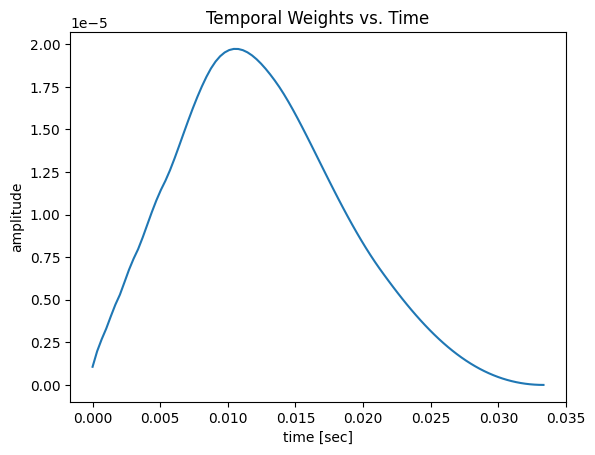

In [78]:
# Check shapes of the operands
print("Model coefficients shape:", model.coef_.shape)  # Should match the number of basis functions
print("Basis kernels shape:", basis_kernels.shape)     # Should correspond to the time points and basis functions

# Correct the einsum operation based on correct alignment
try:
    temp_weights = np.einsum('b, tb -> t', model.coef_, basis_kernels)
except ValueError as e:
    print(f"Error: {e}")

# If there's a mismatch, double-check the alignment between model coefficients and basis functions
# If model.coef_ has extra dimensions, consider using only the relevant parts:
if model.coef_.shape[0] != basis_kernels.shape[1]:
    # Adjust coefficients to match the number of basis functions if needed
    model_coef_adjusted = model.coef_[:basis_kernels.shape[1]]
    temp_weights = np.einsum('b, tb -> t', model_coef_adjusted, basis_kernels)
    print("Adjusted coefficients shape:", model_coef_adjusted.shape)
else:
    temp_weights = np.einsum('b, tb -> t', model.coef_, basis_kernels)

# Plotting the results
plt.plot(time, temp_weights)
plt.xlabel("time [sec]")
plt.ylabel("amplitude")
plt.title("Temporal Weights vs. Time")
plt.show()


In [79]:
model.score(convolved_input, spike_counts, score_type='pseudo-r2-Cohen')

Array(0.00020869, dtype=float32)

## Spike history filter

In [80]:
import pynapple as nap

# Assuming spike_times are in seconds and you want to bin them with 1 ms resolution
start_time = stim_with_time[0, 0]  # Start time of stim_with_time
end_time = stim_with_time[-1, 0]   # End time of stim_with_time

# Create bin edges with 1 ms resolution (0.001 seconds)
bin_size = 0.001  # 1 ms in seconds
bin_edges = np.arange(start_time, end_time + bin_size, bin_size)  # Create bins from start to end with 1 ms intervals

# Bin the spike times using the defined 1 ms bin edges
spike_counts, _ = np.histogram(spike_times, bins=bin_edges)

# Print the shapes to confirm they match
print("Number of bins (spike counts):", spike_counts.shape)  # Number of bins should correspond to the range / 1 ms
print("First few spike counts:", spike_counts[:10])  # Preview the first few spike counts
print("Unique spike counts:", np.unique(spike_counts))  # Check unique values in the spike counts


Number of bins (spike counts): (100500,)
First few spike counts: [0 0 0 0 0 0 0 0 0 0]
Unique spike counts: [0 1]


In [81]:
window_size_sec = 0.8
window_size = int(window_size_sec * 50000)
input_feature = nmo.convolve.create_convolutional_predictor(
    np.eye(window_size), spike_counts)

In [ ]:
model.fit(
    input_feature,spike_counts
)

In [ ]:
# a basis object can be instantiated in "conv" mode for convolving  the input.
basis = nmo.basis.RaisedCosineBasisLog(
    n_basis_funcs=8, mode="conv", window_size=window_size
)

# `basis.evaluate_on_grid` is a convenience method to view all basis functions
# across their whole domain:
time, basis_kernels = basis.evaluate_on_grid(window_size)

print(basis_kernels.shape)

# time takes equi-spaced values between 0 and 1, we could multiply by the
# duration of our window to scale it to seconds.
time *= window_size_sec